In [ ]:
# Datenorganisation
import pandas as pd
import numpy as np
import datetime as dt
import pickle

# Ploterstellung
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Datenvorbereitung
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# Standardeinstellungen
plt.rcParams['axes.xmargin'] = 0
pd.set_option('display.precision',3)
np.set_printoptions(precision=3)

# Tensorflow
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import (Input, LSTM, Dense, Bidirectional, Dropout,Flatten, Concatenate)
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint)
import tensorflow as tf
# Trend, Saisonalität, Residuen und ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from scipy.stats import boxcox
#sonst  Module
import copy
import sys
import os
cwd = os.getcwd()

In [ ]:
#Laden der Daten der WEA
name2 = ['Datum', 'Messwerte']
Erzeugung =  pd.read_excel(r"/content/PV_LG.xlsx",names=name2,sheet_name ="Tabelle1", index_col = 0)
Erzeugung.index = pd.date_range( start='01.01.2018  00:00', end='04.04.2024 22:30', freq='15T')
Erzeugung

Messwerte
2018-01-01 00:00:00        0.0
2018-01-01 00:15:00        0.0
2018-01-01 00:30:00        0.0
2018-01-01 00:45:00        0.0
2018-01-01 01:00:00        0.0
...                        ...
2024-04-04 21:30:00        0.0
2024-04-04 21:45:00        0.0
2024-04-04 22:00:00        0.0
2024-04-04 22:15:00        0.0
2024-04-04 22:30:00        0.0

[219451 rows x 1 columns]

***Volllaststunden***

In [ ]:
VLS = Erzeugung[Erzeugung.index.year == 2022].values.sum()/(151.82*4)
print( "Die Volllaststunden betragen: "+ np.str_(np.round(VLS,1)) +' h')# Laut BDEW passen die Werte

Die Volllaststunden betragen: 1127.8 h


***Nan-Werte***

In [ ]:
Erzeugung.isna().sum()

Messwerte    0
dtype: int64

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(Erzeugung, color='green')
plt.xlabel('Zeit (h)')
plt.ylabel('Messwerte (kW)')
plt.title('Lastgangdaten der PVA')

Text(0.5, 1.0, 'Lastgangdaten der PVA')

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
x = Erzeugung.index
fig.add_trace(go.Scatter(
    x=x,
    y=Erzeugung['Messwerte'],
    name = 'Messwerte',
    connectgaps=True,
    line=dict(color='green')
))
fig.update_layout(title='Lastgang der PVA',
                   xaxis_title='Zeitschritte viertelstündlich (h)',
                   yaxis_title='Leistung (kW)')
fig.show()

Text(0.5, 1.0, 'Verteilung der Messwerte')

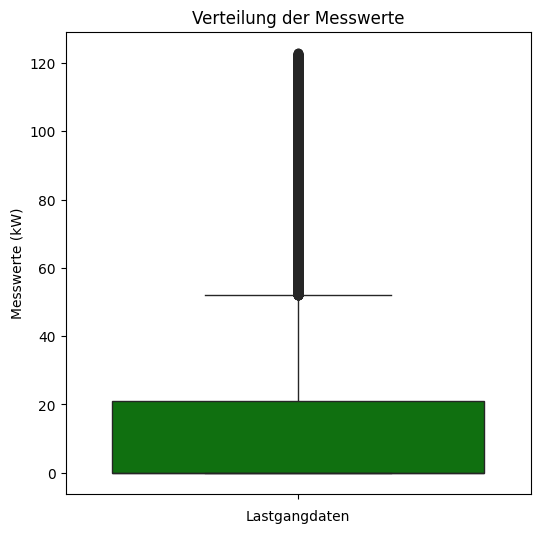

In [ ]:
plt.figure(figsize=(6,6))
sns.boxplot(Erzeugung['Messwerte'], color='green')
plt.ylabel('Messwerte (kW)')
plt.xlabel('Lastgangdaten')
plt.title('Verteilung der Messwerte')

***Min- und Maxleistung***

In [ ]:
Erzeugung.describe()

Messwerte
count  219451.000
mean       17.750
std        30.834
min         0.000
25%         0.000
50%         0.000
75%        20.870
max       123.000

***RLM***

In [ ]:
Erzeugung2021 = Erzeugung[Erzeugung.index.year == 2021]
print('Jahreseinspeisung: ' + np.str_(Erzeugung2021['Messwerte'].sum())  + ' kWh')

Jahreseinspeisung: 599240.68 kWh


***Saisonalität***

<ipython-input-14-3e3353f0485c>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-14-3e3353f0485c>:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Text(0, 0.5, 'Messwerte (kW)')

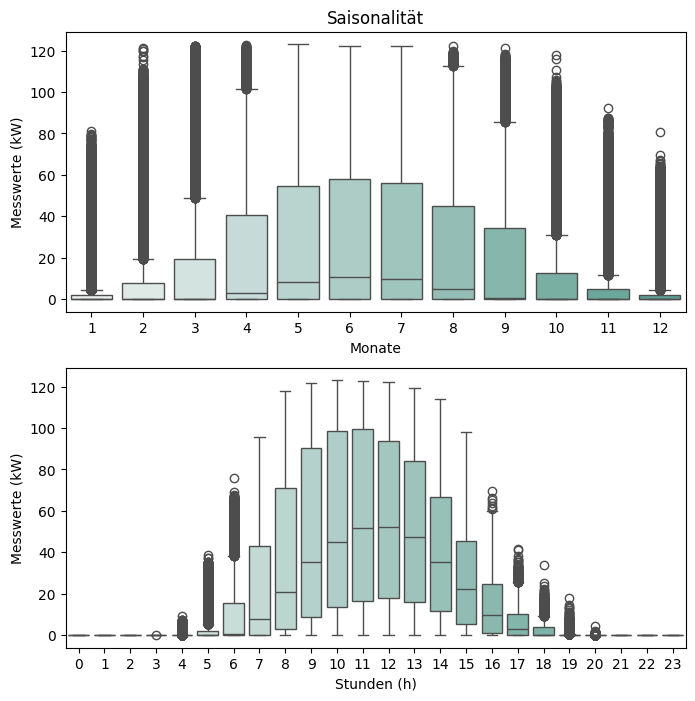

In [ ]:
plt.figure(figsize = (8,8))
plt.subplot(2,1,1)
sns.boxplot(y = Erzeugung['Messwerte'], x =Erzeugung.index.month, palette = "light:#5A9")
plt.xlabel('Monate')
plt.ylabel('Messwerte (kW)')
plt.title('Saisonalität')
plt.subplot(2,1,2)
sns.boxplot(y = Erzeugung['Messwerte'], x =Erzeugung.index.hour, palette = "light:#5A9")
plt.xlabel('Stunden (h)')
plt.ylabel('Messwerte (kW)')

***Trend***

<ipython-input-15-b237d2521c85>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Text(0.5, 1.0, 'Trendkomponent')

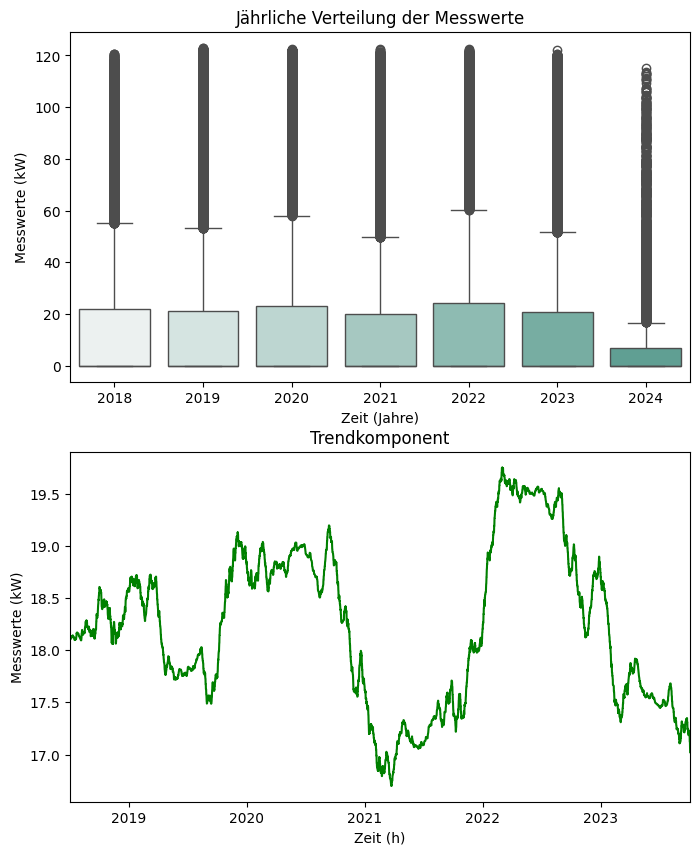

In [ ]:
plt.figure(figsize = (8,10))
plt.subplot(2,1,1)
sns.boxplot(y = Erzeugung['Messwerte'], x =Erzeugung.index.year, palette = "light:#5A9")
plt.xlabel('Zeit (Jahre)')
plt.ylabel('Messwerte (kW)')
plt.title('Jährliche Verteilung der Messwerte')
plt.subplot(2,1,2)
DecomposedErzeugung = seasonal_decompose(Erzeugung, model="additive", period=35040)# Periode = 1h*24*365=8760
plt.plot(DecomposedErzeugung.trend, color='green')
plt.xlabel('Zeit (h)')
plt.ylabel('Messwerte (kW)')
plt.title('Trendkomponent')

Text(0, 0.5, 'Verteilungsdichte')

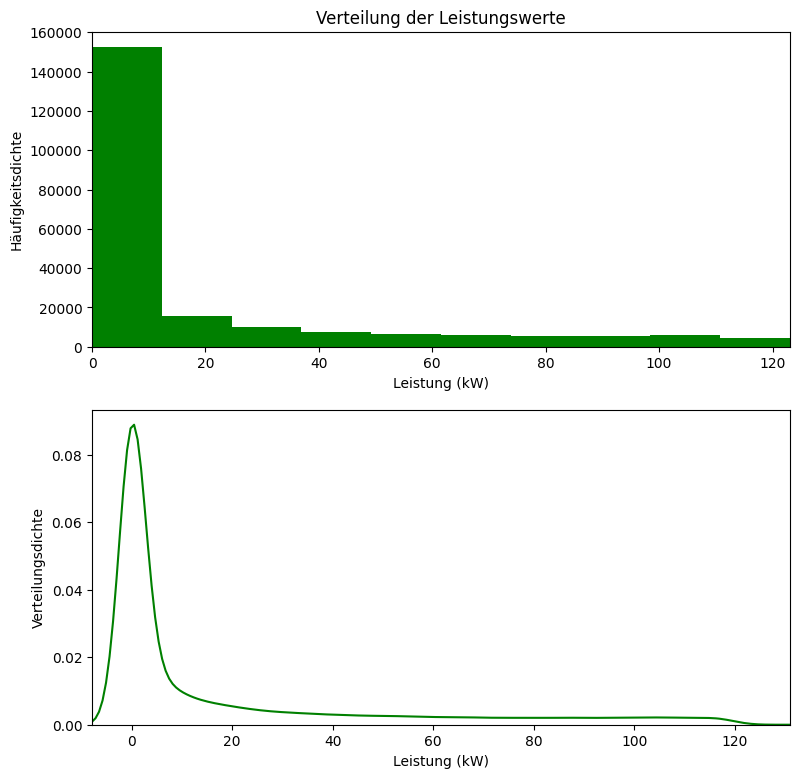

In [ ]:
plt.figure(figsize = (9,9))
plt.subplot(2,1,1)
plt.hist(Erzeugung['Messwerte'], color='green')
plt.xlabel('Leistung (kW)')
plt.ylabel('Häufigkeitsdichte')
plt.title('Verteilung der Leistungswerte')
plt.subplot(2,1,2)
sns.kdeplot(Erzeugung['Messwerte'], color='green')
plt.xlabel('Leistung (kW)')
plt.ylabel('Verteilungsdichte')
#plt.title('Verteilung der Leistungswerte')

In [ ]:
Erzeugung.to_pickle('Erzeugung.pkl')